# Comparative Analysis of CNN and Transfer Learning for Flower Image Classification

This notebook investigates the impact of transfer learning on image classification performance under limited data conditions.

We compare:
- A custom CNN trained from scratch
- A pretrained DenseNet121 model fine-tuned on the target dataset

The objective is to analyze generalization behavior rather than only final accuracy.

# I- Data preparation 

## 1. Data load 

In [4]:
#Imports and Configuration

from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data import AUTOTUNE

In [5]:
# Detect project root
PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / "data" / "jpg"

if not DATA_DIR.exists():
    raise FileNotFoundError(f"{DATA_DIR} introuvable.")

print("Chargement des données depuis :", DATA_DIR)


Chargement des données depuis : /Users/admin/Desktop/flower-image-classification/data/jpg


In [6]:
# Load datasets
train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=16
)

val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=16
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes :", class_names)



Found 320 files belonging to 4 classes.
Using 256 files for training.
Found 320 files belonging to 4 classes.
Using 64 files for validation.
Classes : ['0', '2', '4', '9']


In [7]:
# Optimize input pipeline
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

## 2. Data augmentation 

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


# II-Baseline CNN

## 1. Architecture and Training




In [3]:
model = models.Sequential([

    layers.Input(shape=(128, 128, 3)),

    # Normalize pixel values to [0,1]
    layers.Rescaling(1./255),

    # Data augmentation
    data_augmentation,

    # ---------------- Block 1 ----------------
    layers.Conv2D(64, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(64, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # ---------------- Block 2 ----------------
    layers.Conv2D(128, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(128, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # ---------------- Block 3 ----------------
    layers.Conv2D(256, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # ---------------- Block 4 ----------------
    layers.Conv2D(256, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # Global pooling instead of Flatten
    layers.GlobalAveragePooling2D(),

    # Classification head
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 1,282,628 (4.89 MB)

 Trainable params: 1,280,836 (4.89 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6484 - loss: 0.8506 - val_accuracy: 0.2656 - val_loss: 1.7256
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8008 - loss: 0.4894 - val_accuracy: 0.6562 - val_loss: 0.8675
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8164 - loss: 0.4988 - val_accuracy: 0.5000 - val_loss: 1.2710
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8203 - loss: 0.5065 - val_accuracy: 0.4375 - val_loss: 1.4612
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8281 - loss: 0.4406 - val_accuracy: 0.5469 - val_loss: 1.1433
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8281 - loss: 0.4894 - val_accuracy: 0.5781 - val_loss: 1.0166
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8047 - loss: 0.5005 - val_accuracy: 0.4688 - val_loss: 1.5167


This code defines a CNN for 128×128 image classification.

Images are first normalized and augmented using data augmentation.
The model consists of four convolutional blocks with Conv2D, Batch Normalization, ReLU activation, and MaxPooling, with increasing filters (64 → 256).

A GlobalAveragePooling layer reduces the spatial dimensions before a 512-unit dense layer with Dropout, followed by a softmax output layer for multi-class classification.

The model is compiled with Adam and trained using early stopping to prevent overfitting.

## 2. Model Evaluation and Performance Analysis


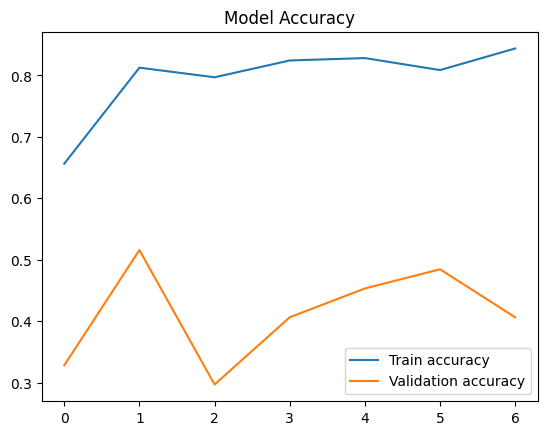

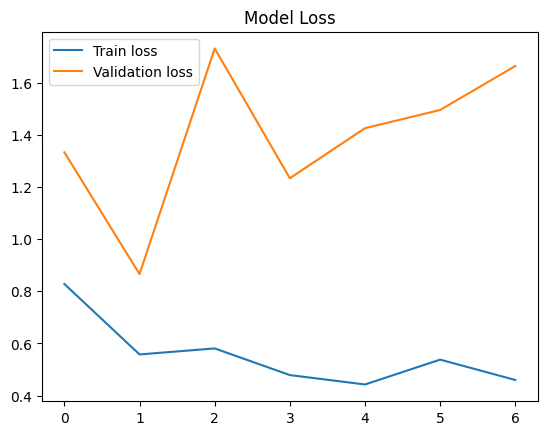

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
Confusion Matrix:
[[10  9  0  0]
 [ 0 18  1  0]
 [ 1  8  4  0]
 [11  1  0  1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.53      0.49        19
           2       0.50      0.95      0.65        19
           4       0.80      0.31      0.44        13
           9       1.00      0.08      0.14        13

    accuracy                           0.52        64
   macro avg       0.69      0.46      0.43        64
weighted avg       0.65      0.52      0.46        64



2026-02-15 23:03:43.424505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Learning curves
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title("Model Loss")
plt.show()

# Confusion matrix and classification report
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


The model shows clear signs of overfitting: while training loss decreases steadily, validation loss increases and validation accuracy remains unstable. This is likely due to the relatively small dataset compared to the model capacity (1.28M parameters). Additional regularization or more data would be required to improve generalization.

The confusion matrix reveals uneven class performance. While class 2 is correctly classified with high recall (0.95), class 9 is almost never correctly predicted (recall 0.08). The macro F1-score (0.43) indicates poor balanced performance across classes. This confirms the presence of overfitting and limited generalization, likely due to the small dataset size relative to model capacity.

To improve the results, several strategies could be explored. First, stronger regularization could be applied by reducing model capacity (e.g., decreasing the size of the dense layer), increasing dropout, or lowering the learning rate. Second, more aggressive data augmentation could help improve generalization. Finally, collecting more training data or using transfer learning with a pretrained model could significantly enhance performance and class balance.

## 3. Improvement 

In [ ]:
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf

# Stronger data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

model2 = models.Sequential([

    layers.Input(shape=(128, 128, 3)),

    # Normalize inputs
    layers.Rescaling(1./255),

    # Data augmentation
    data_augmentation,

    # -------- Block 1 --------
    layers.Conv2D(64, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # -------- Block 2 --------
    layers.Conv2D(128, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # -------- Block 3 --------
    layers.Conv2D(256, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # -------- Block 4 --------
    layers.Conv2D(256, (3, 3), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),

    # Reduced dense layer (less capacity)
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.4),

    layers.Dense(num_classes, activation="softmax")
])

# Lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model2.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model2.summary()


early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[early_stop, reduce_lr]
)



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,030,532 (3.93 MB)

 Trainable params: 1,029,124 (3.93 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6172 - loss: 0.9255 - val_accuracy: 0.2969 - val_loss: 1.3566 - learning_rate: 1.0000e-04
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7539 - loss: 0.6429 - val_accuracy: 0.2969 - val_loss: 1.3493 - learning_rate: 1.0000e-04
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8320 - loss: 0.4876 - val_accuracy: 0.4062 - val_loss: 1.3632 - learning_rate: 1.0000e-04
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8281 - loss: 0.4758 - val_accuracy: 0.3281 - val_loss: 1.3941 - learning_rate: 1.0000e-04
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8398 - loss: 0.4356 - val_accuracy: 0.2969 - val_loss: 1.4483 - learning_rate: 1.0000e-04
Epoch 6/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8750 - loss: 0.4227 - val_accuracy: 0.2969 - val_loss: 1.5120 - learning_rate: 5.0000e-05
Epoch 7/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8516 - loss:

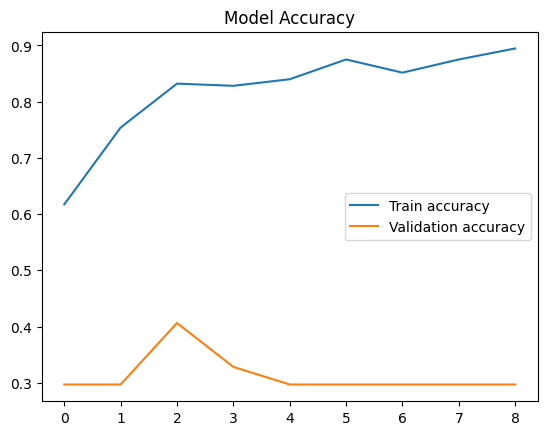

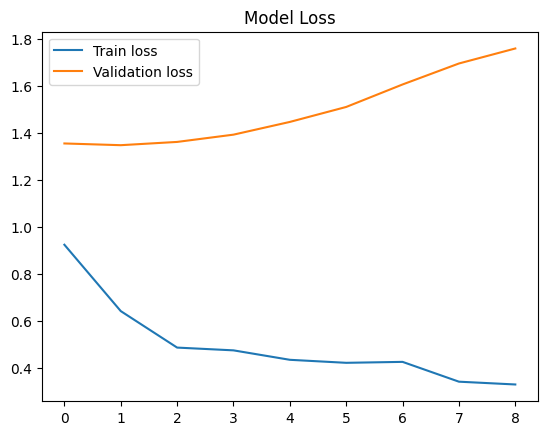

Confusion Matrix:
[[19  0  0  0]
 [19  0  0  0]
 [13  0  0  0]
 [13  0  0  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46        19
           2       0.00      0.00      0.00        19
           4       0.00      0.00      0.00        13
           9       0.00      0.00      0.00        13

    accuracy                           0.30        64
   macro avg       0.07      0.25      0.11        64
weighted avg       0.09      0.30      0.14        64



2026-02-15 23:23:11.462102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/admin/Desktop/flower-image-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/admin/Desktop/flower-image-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/admin/Desktop/flower-image-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.p

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# =========================
# Learning curves
# =========================

plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title("Model Loss")
plt.show()

# =========================
# Confusion matrix
# =========================

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model2.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

# =========================
# Classification report
# =========================

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


The improved model collapsed to predicting a single class on the validation set, resulting in 30% accuracy. The confusion matrix shows that all validation samples were classified as class 0. This indicates severe overfitting and poor generalization, likely due to the small dataset size relative to model capacity.

# II- Transfer Learning with DenseNet121

## 1. Architecture and Training

In [9]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras import layers, Model, Input

# Load the DenseNet121 model without the top classification layer
# We use pre-trained weights from ImageNet to take advantage of transfer learning
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

# Freeze the pre-trained layers to avoid updating their weights during training
base_model.trainable = False

# Define the input layer for our new model
inputs = Input(shape=(128, 128, 3))

# Apply the preprocessing function required by DenseNet121
x = preprocess_input(inputs)

# Pass the inputs through the frozen DenseNet121 base
x = base_model(x, training=False)

# Add a global average pooling layer to reduce the output dimensions
x = layers.GlobalAveragePooling2D()(x)

# Add a dense layer to learn new features for our specific task
x = layers.Dense(256, activation='relu')(x)

# Add a dropout layer to prevent overfitting
x = layers.Dropout(0.5)(x)

# Add the final output layer with softmax activation for 4-class classification
outputs = layers.Dense(4, activation='softmax')(x)

# Create the complete model
densenet_model = Model(inputs, outputs)

# Compile the model using the Adam optimizer and a suitable loss for integer labels
densenet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display the architecture and number of parameters of the model
densenet_model.summary()

# Train the model on the same dataset as the custom CNN
history_densenet = densenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 263,428 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7031 - loss: 0.9551 - val_accuracy: 0.9062 - val_loss: 0.3746
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 696ms/step - accuracy: 0.9492 - loss: 0.1404 - val_accuracy: 0.9531 - val_loss: 0.1102
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 684ms/step - accuracy: 0.9648 - loss: 0.1233 - val_accuracy: 0.9844 - val_loss: 0.0451
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 681ms/step - accuracy: 0.9883 - loss: 0.0283 - val_accuracy: 0.9688 - val_loss: 0.0793
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 691ms/step - accuracy: 0.9844 - loss: 0.0382 - val_accuracy: 0.9688 - val_loss: 0.0622
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 673ms/step - accuracy: 1.0000 - loss: 0.0121 - val_accuracy: 0.9844 - val_loss: 0.0663
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 665ms/step - accuracy: 0.9961 - loss: 0.0187 - val_accuracy: 0.9688 - val_loss: 0.0591
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 663ms/step - accuracy: 0.9961 - loss: 0.0231 - val_accurac

## 2. Model Evaluation and Performance Analysis

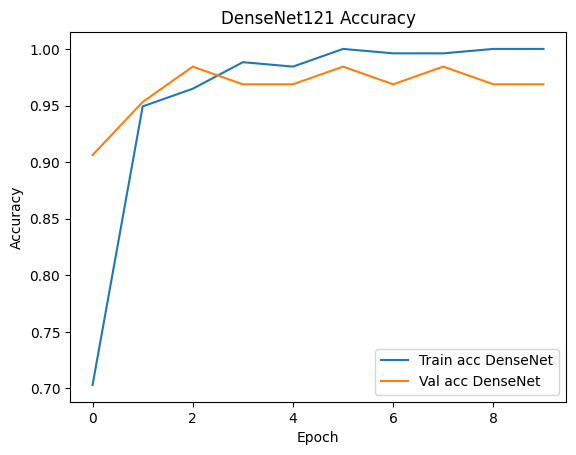

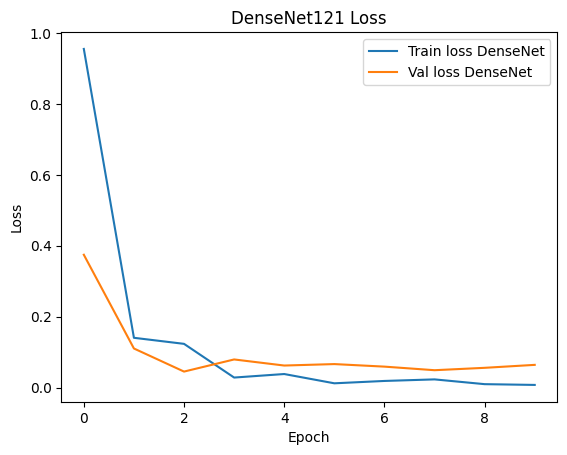

Confusion Matrix:
[[18  1  0  0]
 [ 0 19  0  0]
 [ 0  0 13  0]
 [ 0  0  0 13]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           2       0.95      1.00      0.97        19
           4       1.00      1.00      1.00        13
           9       1.00      1.00      1.00        13

    accuracy                           0.98        64
   macro avg       0.99      0.99      0.99        64
weighted avg       0.99      0.98      0.98        64



2026-02-15 23:29:35.721815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
# Plot the learning curves for DenseNet121
# This helps visualize how the training and validation accuracy and loss evolve over epochs

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# =========================
# Accuracy curves
# =========================
plt.plot(history_densenet.history['accuracy'], label='Train acc DenseNet')
plt.plot(history_densenet.history['val_accuracy'], label='Val acc DenseNet')
plt.legend()
plt.title("DenseNet121 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# =========================
# Loss curves
# =========================
plt.plot(history_densenet.history['loss'], label='Train loss DenseNet')
plt.plot(history_densenet.history['val_loss'], label='Val loss DenseNet')
plt.legend()
plt.title("DenseNet121 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


# =========================
# Confusion Matrix + Report
# =========================

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = densenet_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Transfer learning with DenseNet121 significantly improved performance compared to training a CNN from scratch. The model achieved 98% validation accuracy with balanced precision and recall across all classes. This highlights the importance of pretrained representations when working with small datasets.


# III-Comparison Between Custom CNN and DenseNet121


## Which model is better?

While the assignment required a model with 1–3 million parameters, the CNN trained from scratch did not generalize well. Despite achieving high training accuracy, validation performance remained unstable and in some cases collapsed to predicting a single class.

This behavior is explained by the small dataset size (approximately 256 training images) relative to the model capacity. A network with over one million parameters has high expressive power and can easily overfit such a limited dataset. As a result, the model memorized training samples instead of learning robust, transferable features.

In contrast, transfer learning with DenseNet121 significantly improved performance. The model achieved 98% validation accuracy with balanced precision and recall across all classes. This highlights the importance of pretrained representations when working with small datasets, as they reduce variance and improve generalization.


In [13]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the test image
img_path = '/Users/admin/Desktop/flower-image-classification/test.jpg'
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# For DenseNet, use its specific preprocessing
img_array_densenet = preprocess_input(np.copy(img_array))

# Predict with the custom CNN
pred_cnn = model.predict(img_array)
pred_class_cnn = class_names[np.argmax(pred_cnn)]

# Predict with DenseNet121
pred_densenet = densenet_model.predict(img_array_densenet)
pred_class_densenet = class_names[np.argmax(pred_densenet)]

# Show predictions
print("Custom CNN Prediction:", pred_class_cnn)
print("DenseNet121 Prediction:", pred_class_densenet)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Custom CNN Prediction: 0
DenseNet121 Prediction: 2


The CNN trained from scratch misclassified the test image, whereas the DenseNet121 model predicted the correct class. This confirms the previous analysis: the CNN overfitted due to the limited size of the training dataset relative to its model capacity (over one million parameters). In contrast, transfer learning provided more robust feature representations and better generalization on unseen data.